In [175]:
import numpy as np
import pandas as pd
import spacy
import sklearn as sk

In [177]:
import meilisearch

# CAUTION: PRODUCTION 
MEILISEARCH_URL = "http://104.248.158.11"
MEILISEARCH_KEY = "NDUyZDNiYTM1Njk3ZjM3MzM1MjRiZTVl"

client = meilisearch.Client(MEILISEARCH_URL, MEILISEARCH_KEY)
index = client.index("articles")

In [178]:
index.update_ranking_rules([
    'words',
    'sort',
    'typo',
    'proximity',
    'attribute',
    'exactness'
])
# NOTE: Since `sort` isn't on top, the results are only mostly sorted by publishedTime

index.update_displayed_attributes([
    "*"
])
# For `search` to return content and embeddings

{'taskUid': 9823,
 'indexUid': 'articles',
 'status': 'enqueued',
 'type': 'settingsUpdate',
 'enqueuedAt': '2023-01-09T08:16:22.224891952Z'}

In [241]:
search_term = "croatia joins euro"
response = index.search(
    search_term, 
    {
        "limit": 1000,
        "attributesToRetrieve": ["uuid","publishedTime"],
        "sort": ["publishedTime:asc"]
    }
)
result = response["hits"]
total_hits = response["estimatedTotalHits"]

In [242]:
response

{'hits': [{'uuid': '96fef3dc-793d-4db3-8b52-8bcb305e022c',
   'publishedTime': 1672399236},
  {'uuid': 'b7f51f57-db39-47e0-b628-905a1d9940aa',
   'publishedTime': 1672537112},
  {'uuid': '2e582e35-54c5-45c3-8864-e5c29b6bb2d4',
   'publishedTime': 1672589074},
  {'uuid': '990cddae-a69d-44eb-852a-7fa0cc88b0a5',
   'publishedTime': 1672589586},
  {'uuid': '086d2d24-e14d-4868-bc7b-bf0c0ff3ded6',
   'publishedTime': 1672774729},
  {'uuid': '26eaddb0-3264-42c8-a731-0fa925cf3343',
   'publishedTime': 1672999215},
  {'uuid': 'e505f438-271c-4018-a6b2-28e3cde5c4e8',
   'publishedTime': 1671444074},
  {'uuid': 'c8da8197-89bd-440b-9056-7bb428400e43',
   'publishedTime': 1671472943},
  {'uuid': '2fbe5bec-dc83-4cee-ab2f-dfe4cebcf896',
   'publishedTime': 1671482800},
  {'uuid': '8a84b92c-9686-43c7-a90a-5cf9bbdcd3fc',
   'publishedTime': 1671745682},
  {'uuid': 'b8e27a07-58f6-4e15-a876-7e0145215176',
   'publishedTime': 1671897888},
  {'uuid': '263775ad-ade9-49fb-b552-9a68007c1d77',
   'publishedTime

In [243]:
total_hits

40

In [244]:
# TODO: variable limit and iterate until limit done
def get_articles(meilisearch_index, term, sources=None):
    response = meilisearch_index.search(
        search_term,
        {
            "limit": 1000,
            "attributesToRetrieve": ["*"],
            "sort": ["publishedTime:asc"]
        }
    )
    articles = response["hits"]
    return articles
    


In [245]:
articles = get_articles(index, search_term)

In [246]:
df = pd.DataFrame.from_records(articles)

In [247]:
import re

def convert_df_column_names_to_camel_case(df):
    pattern = re.compile(r'(?<!^)(?=[A-Z])')
    new_column_names = [pattern.sub('_', col).lower() for col in df.columns]
    old_to_new_name_map = {
        col: pattern.sub('_', col).lower()
        for col in df.columns
    }
    return df.rename(columns=old_to_new_name_map)

df = convert_df_column_names_to_camel_case(df)

In [248]:
df.published_time = pd.to_datetime(df.published_time, unit="s")

In [249]:
from datetime import timedelta

def daterange(start_date, end_date, step=timedelta(days=1)):
    for n in range(0, int((end_date - start_date).days), step.days):
        yield start_date + timedelta(n)

def partition_data_into_windows(df, window_delta=0, step=1):
    '''
    Returns a list of DataFrames, where each DataFrame contains 
    articles published on some day += window_delta. 

    Examples: 
        Parameters           Days contained in each window
    window_delta=0, step=1 --> [4-4, 5-5, 6-6, ...]
    window_delta=1, step=1 --> [3-5, 4-6, 5-7, ...]
    window_delta=2, step=1 --> [2-6, 3-7, 4-8, ...]
    window_delta=0, step=2 --> [4-4, 6-6, 8-8, ...]
    '''

    windows = []

    window_size = timedelta(days=window_delta)
    start_date = df.published_time.dt.date.min()
    end_date = df.published_time.dt.date.max()

    for d in daterange(start_date + window_size,
                       end_date - window_size + timedelta(days=1), 
                       timedelta(days=step)):
        lower_bound = d - window_size 
        upper_bound = d + window_size
        is_within_window = (lower_bound <= df.published_time.dt.date) & (df.published_time.dt.date <= upper_bound)
        data_within_window = df[is_within_window]
        windows.append(data_within_window)
    
    return windows

In [250]:
sliding_windows = partition_data_into_windows(df, 1, 3)

In [251]:
if len(df) < 200:
    min_samples = 2
else:
    min_samples = 3

sliding_windows = [window for window in sliding_windows if len(window) >= min_samples]

# Visualizing the date distribution

[(3, Timestamp('2022-12-19 10:01:14')),
 (2, Timestamp('2022-12-22 21:48:02')),
 (13, Timestamp('2022-12-30 11:20:36')),
 (7, Timestamp('2023-01-01 01:38:32')),
 (4, Timestamp('2023-01-03 19:38:49'))]

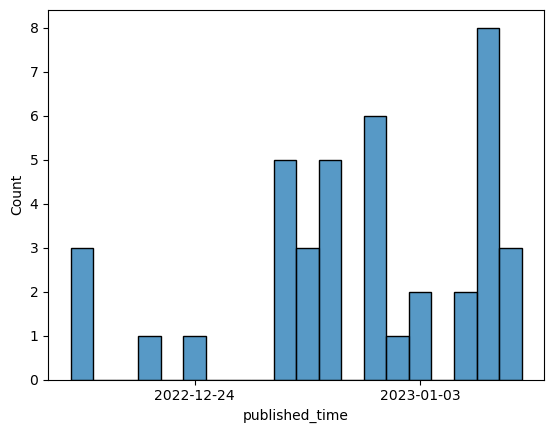

In [252]:
import seaborn as sns
import matplotlib.ticker as ticker

# Plot
ax = sns.histplot(df.published_time.dt.date)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

# List
[(len(window), window.iloc[0].published_time if len(window) > 0 else "") for window in sliding_windows]

# Clustering

In [253]:
from sklearn.cluster import OPTICS

def partition_into_clusters(data, fitted_model):
    '''
    Given a DataFrame and a model fitted on that DataFrame, 
    returns a list of DataFrames, where each DataFrame contains 
    data of the same cluster, as labelled by the fitted_model.
    '''

    labels = np.unique(fitted_model.labels_)
    data = [data[fitted_model.labels_ == label] for label in labels]
    return data

def cluster_each_window(model, sliding_windows, keep_embeddings=False):
    '''
    Given a model and a list of DataFrames, where sliding_windows[w] is a DataFrame of articles,  
    Returns a list of list of DataFrames, where clusters_for_each_window[w][c]
    is the DataFrame corresponding to the c-th cluster for the w-th window.
    '''

    clusters_for_each_window = []
    for window in sliding_windows:
        x = np.stack(window.embeddings)
        model = model.fit(x)
        
        if not keep_embeddings:
            window = window.drop(columns=['embeddings'])

        clusters = partition_into_clusters(window, model)
        clusters_for_each_window.append(clusters)
    return clusters_for_each_window

optics = OPTICS(min_samples=min_samples, xi=0.05)
clusters_for_each_window = cluster_each_window(optics, sliding_windows, keep_embeddings=True)

In [254]:
[len(clusters) for clusters in clusters_for_each_window]

[1, 1, 5, 1, 1]

In [255]:
def display_series(series):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', 80)
    display(series)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

display_series(clusters)

[                                                                              title  \
 16  At Istanbul's Queer Olympix, the aim is for LGBTQ+ athletes to have fun and ...   
 18                   Timeline: Case of Charles Sobhraj – ‘Bikini Killer’, ‘Serpent’   
 
                                                                         description  \
 16  The organizers of the annual sports festival in Istanbul see it as an opport...   
 18  The French serial killer preyed on Western tourists on the ‘hippie trail’ in...   
 
                                                                             content  \
 16  Every summer since 2017, Istanbul has played host to a sporting event known ...   
 18  Charles Sobhraj, a French serial killer who police say is responsible for a ...   
 
                                     uuid  \
 16  bc7f7ee8-34d3-40ad-9dc5-a0c762c30a4d   
 18  369c0e97-e281-4977-b970-0590c51d3e96   
 
                                                                 

In [ ]:
clusters_for_each_window[0][4]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/cyanaspect/opt/anaconda3/envs/ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kg/5sdfljwd58339hwyr4gl3bvh0000gn/T/ipykernel_9521/3680598616.py", line 1, in <module>
    clusters_for_each_window[0][4]
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cyanaspect/opt/anaconda3/envs/ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IndexError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cyanaspect/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <mod

# Reclustering "useless" articles
Findings: Seems like its not useful

In [256]:
model_for_useless_articles = OPTICS(min_samples=2, xi=0.05)
useless_articles = clusters_for_each_window[1][0]

x = np.stack(useless_articles.embeddings)
model_for_useless_articles = model_for_useless_articles.fit(x)
clusters = partition_into_clusters(useless_articles, model_for_useless_articles)

In [257]:
[len(c) for c in clusters]

ERROR! Session/line number was not unique in database. History logging moved to new session 263


[2]

In [ ]:
display_series(clusters[5].title)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/cyanaspect/opt/anaconda3/envs/ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kg/5sdfljwd58339hwyr4gl3bvh0000gn/T/ipykernel_9521/1295585183.py", line 1, in <module>
    display_series(clusters[5].title)
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cyanaspect/opt/anaconda3/envs/ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IndexError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cyanaspect/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <

# Parsing into events

In [258]:
import copy

def remove_largest_cluster_of_each_window(clusters_for_each_window):
    '''
    Given a list of list of DataFrames, where clusters_for_each_window[w][c]
    is the DataFrame corresponding to the c-th cluster for the w-th window,
    remove the largest cluster from each window.
    '''
    # Have to define custom helper function because remove(max(...)) raises
    # ValueError: Can only compare df with same index
    def remove_largest_df_in_list(dfs):
        largest_df_idx = 0
        for i in range(len(dfs)):
            if len(dfs[i]) > len(dfs[largest_df_idx]):
                largest_df_idx = i
        del dfs[largest_df_idx]
        
    clusters_for_each_window = copy.deepcopy(clusters_for_each_window)
    for clusters_for_window in clusters_for_each_window:
        remove_largest_df_in_list(clusters_for_window)
    return clusters_for_each_window

clusters_for_each_window = remove_largest_cluster_of_each_window(clusters_for_each_window)

ERROR! Session/line number was not unique in database. History logging moved to new session 264


In [259]:
from sklearn.metrics import pairwise_distances_argmin_min

def get_event_title(event):
    '''
    Given an event (a DataFrame of articles),
    Returns the title of that event.
    '''
    embeddings = [embedding for embedding in event.embeddings]
    mean_embedding = np.array([np.mean(embeddings, axis=0)])
    index = pairwise_distances_argmin_min(mean_embedding, embeddings)[0][0]
    return event.title.iloc[index]

def get_modal_date(event):
    '''
    Given an event (a DataFrame of articles),
    Returns the modal date of articles in that event.
    '''
    dates = event.published_time.dt.date
    return dates.mode()[0]

def to_article_dicts(event):
    '''
    Given a DataFrame representing a cluster of articles, 
    Returns a list of dictionaries, where each dictionary is an article.
    '''
    event = event.drop(columns=['content', 'embeddings']) 
    return event.to_dict('records')

def parse_into_events(clusters_for_each_window):
    '''
    Given a list of list of DataFrames, where clusters_for_each_window[w][c]
    is the DataFrame corresponding to the c-th cluster for the w-th window,
    Returns a list of events sorted by date, where each event is a dictionary:
    {
        'name': string
        'date': date
        'articles': [
            {
                'title': string
                'published_time': date
                'url': string
                'thumbnail_url': string
            }, 
        ]
    }
    '''
    events = []
    for window in clusters_for_each_window:
        for cluster in window:
            event = {
                'name': get_event_title(cluster),
                'date': get_modal_date(cluster).isoformat(), 
                'articles': to_article_dicts(cluster)
            }
            events.append(event)
    return sorted(events, key=lambda event : event['date'], reverse=True)


events = parse_into_events(clusters_for_each_window)

In [262]:
events[2]

{'name': 'Nearly-man Moriyasu remains in charge of Japan for another four-year cycle',
 'date': '2022-12-28',
 'articles': [{'title': "Japan's World Cup coach Moriyasu to stay until 2026",
   'description': "The coach of Japan's national soccer team, Hajime Moriyasu, who led the Samurai Blue to the knock-out stage of the Qatar World Cup, will stay on to lead the team into the next World Cup in 2026, the Japan Football Association said on Wednesday.",
   'uuid': '263775ad-ade9-49fb-b552-9a68007c1d77',
   'thumbnail_url': 'https://www.reuters.com/resizer/6-aq20NIlpe7zu_diPjsZRC9ybI=/1200x628/smart/filters:quality(80)/cloudfront-us-east-2.images.arcpublishing.com/reuters/JCRFMFRN6BORNPXOGCOV3VFE74.jpg',
   'url': 'https://www.reuters.com/lifestyle/sports/japans-world-cup-coach-moriyasu-stay-until-2026-2022-12-28/',
   'published_time': Timestamp('2022-12-28 10:26:14'),
   'source': 'reuters.com'},
  {'title': 'Nearly-man Moriyasu remains in charge of Japan for another four-year cycle',
  